In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import RocCurveDisplay
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.metrics import log_loss, accuracy_score
from sklearn.metrics import f1_score
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import GridSearchCV

In [3]:
with open('predictive_maintainance_1.csv', 'r') as file:
    lines = file.readlines()

# Split lines into columns based on the first 8 spaces or tabs
data = [line.strip().split(None, 9) for line in lines]

# Create a DataFrame from the data
df = pd.DataFrame(data, columns=['UDI', 'Product_ID', 'Type', 'Air_temperature_[K]', 'Process_temperature_[K]', 'Rotational_speed_[rpm]', 'Torque_[Nm]', 'Tool_wear_[min]', 'Target', 'Failure_Type'])

df['Type'] = df['Type'].replace({'L': 0 , 'M': 1 , 'H': 2 })

#remove columns Product_ID, UDI,
df = df.drop(columns=['UDI','Product_ID', 'Failure_Type'])
df = df.drop(columns=['Type'])

# cast values into float
df = df.astype(float)

# Display the DataFrame
print(df.head())
print(df.shape)

   Air_temperature_[K]  Process_temperature_[K]  Rotational_speed_[rpm]  \
0                298.1                    308.6                  1551.0   
1                298.2                    308.7                  1408.0   
2                298.1                    308.5                  1498.0   
3                298.2                    308.6                  1433.0   
4                298.2                    308.7                  1408.0   

   Torque_[Nm]  Tool_wear_[min]  Target  
0         42.8              0.0     0.0  
1         46.3              3.0     0.0  
2         49.4              5.0     0.0  
3         39.5              7.0     0.0  
4         40.0              9.0     0.0  
(10000, 6)


In [4]:
df_failure = df[df['Target'] == 1]
df_no_failure = df[df['Target'] == 0]



# Split the DataFrame into features and target variables
# falure dataset
X_failure = df_failure.drop('Target', axis=1)  # Features
y_failure = df_failure['Target']  # Target variable

# no falure dataset
X_no_failure = df_no_failure.drop('Target', axis=1)  # Features
y_no_failure = df_no_failure['Target']  # Target variable

# spliting the datasets into training and validation
# failure data set
X_train_failure, X_test_failure, y_train_failure, y_test_failure = train_test_split(
    X_failure, y_failure, test_size=0.1, random_state=0)

# no_failure dataset
X_train_no_failure, X_test_no_failure, y_train_no_failure, y_test_no_failure = train_test_split(
    X_no_failure, y_no_failure, test_size=0.1, random_state=0)


# merge the taining data set
X_train = pd.concat([X_train_failure, X_train_no_failure], ignore_index =True)
y_train = pd.concat([y_train_failure, y_train_no_failure], ignore_index =True)

# merging the test dataset
X_test = pd.concat([X_test_failure, X_test_no_failure], ignore_index =True)
y_test = pd.concat([y_test_failure, y_test_no_failure], ignore_index =True)

# implementing biased sampling method
smote = SMOTE(random_state=42)
X_resampled, y_resampled = smote.fit_resample(X_train, y_train)


In [5]:
# Define the parameter grid
param_grid = {
    'C': [0.1, 1, 10],
    'gamma': [0.1, 0.01, 0.001]
}

# Create SVM classifier
svm = SVC()

# Instantiate GridSearchCV
grid_search = GridSearchCV(estimator=svm, param_grid=param_grid, cv=9, scoring='accuracy')

# Perform grid search on the training data
grid_search.fit(X_resampled, y_resampled)

# Print the best parameters found
print("Best Parameters:", grid_search.best_params_)

# Get the best estimator
best_svm = grid_search.best_estimator_

# Evaluate the best estimator on the test data
test_accuracy = best_svm.score(X_test, y_test)
print("Test Accuracy:", test_accuracy)


test_failure_accuracy = accuracy_score(y_test_failure, best_svm.predict(X_test_failure))
test_no_failure_accuracy = accuracy_score(y_test_no_failure, best_svm.predict(X_test_no_failure))

# F1 score calucation of the model
f1 = f1_score(y_test, best_svm.predict(X_test))

print(f"rbf SVM - Test Accuracy for failure only dataset: {test_failure_accuracy:.2f}")
print(f"rbf SVM - Test Accuracy for no failure only dataset: {test_no_failure_accuracy:.2f}")

# Display the F1 score
print("rbf SVM - F1 Score:", f1)

Best Parameters: {'C': 10, 'gamma': 0.01}
Test Accuracy: 0.9340659340659341
rbf SVM - Test Accuracy for failure only dataset: 0.41
rbf SVM - Test Accuracy for no failure only dataset: 0.95
rbf SVM - F1 Score: 0.2978723404255319


In [7]:
train_accuracy = accuracy_score(y_resampled, best_svm.predict(X_resampled))
print(f"rbf SVM - Training Accuracy: {train_accuracy:.2f}")

rbf SVM - Training Accuracy: 0.99


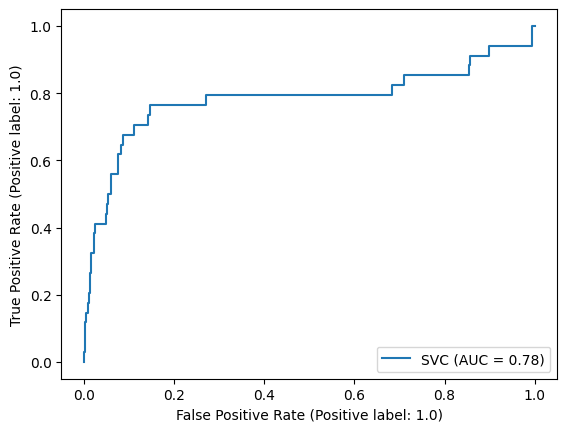

In [6]:
# Visulalization
svm_disp = RocCurveDisplay.from_estimator(best_svm, X_test, y_test)